In [1]:
!pip install rdkit
!pip install mol2vec

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.8/32.8 MB 25.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 28.0 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from mol2vec.features import mol2alt_sentence, MolSentence, sentences2vec
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans

In [3]:
#Cargar la base de datos
file_path = "nueva_base.csv"  # Cambia por tu archivo
data = pd.read_csv(file_path)

In [4]:
#Codificar las etiquetas
label_encoder = LabelEncoder()
data['Activity'] = label_encoder.fit_transform(data['Activity'])  # Antibacterial -> 1, Otros -> 0

In [5]:
# Función para convertir secuencias en moléculas RDKit
def sequence_to_molecule(sequence):
    try:
        smiles = sequence  # Si tienes un conversor SMILES, úsalo aquí
        mol = Chem.MolFromSequence(sequence)
        return mol
    except:
        return None


In [6]:
#Función para generar fingerprints
def generate_fingerprint(molecule):
    if molecule:
        return AllChem.GetMorganFingerprintAsBitVect(molecule, radius=2, nBits=2048)
    else:
        return None

In [9]:
# Convertir secuencias a moléculas y generar fingerprints
data['Molecule'] = data['Seqence'].apply(sequence_to_molecule)
data['Fingerprint'] = data['Molecule'].apply(generate_fingerprint)

[20:46:29] DEPRECATION WARNING: please use MorganGenerator
[20:46:29] DEPRECATION WARNING: please use MorganGenerator
[20:46:29] DEPRECATION WARNING: please use MorganGenerator
[20:46:29] DEPRECATION WARNING: please use MorganGenerator
[20:46:29] DEPRECATION WARNING: please use MorganGenerator
[20:46:29] DEPRECATION WARNING: please use MorganGenerator
[20:46:29] DEPRECATION WARNING: please use MorganGenerator
[20:46:29] DEPRECATION WARNING: please use MorganGenerator
[20:46:29] DEPRECATION WARNING: please use MorganGenerator
[20:46:29] DEPRECATION WARNING: please use MorganGenerator
[20:46:29] DEPRECATION WARNING: please use MorganGenerator
[20:46:29] DEPRECATION WARNING: please use MorganGenerator
[20:46:29] DEPRECATION WARNING: please use MorganGenerator
[20:46:29] DEPRECATION WARNING: please use MorganGenerator
[20:46:29] DEPRECATION WARNING: please use MorganGenerator
[20:46:29] DEPRECATION WARNING: please use MorganGenerator
[20:46:29] DEPRECATION WARNING: please use MorganGenerat

In [10]:
# Filtrar datos con fingerprints válidos
data = data[data['Fingerprint'].notna()]
fingerprints = np.array(data['Fingerprint'].tolist())

In [11]:
#Reducción de dimensionalidad con PCA
pca = PCA(n_components=50)  # Reducir a 50 componentes
fingerprints_pca = pca.fit_transform(fingerprints)

"""
PCA (Análisis de Componentes Principales):
Reduce las dimensiones de los fingerprints de 2048 a 50, conservando la mayor variabilidad posible.
Mejora la eficiencia y prepara los datos para t-SNE.

"""

In [13]:
#Reducción de dimensionalidad con t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
fingerprints_2d = tsne.fit_transform(fingerprints_pca)
"""
TSNE (T-distributed Stochastic Neighbor Embedding):
Reduce las dimensiones de 50 a 2 para graficar los datos en un plano bidimensional.
perplexity=30: Parámetro que controla el equilibrio entre datos locales y globales.
random_state=42: Semilla para reproducibilidad.
fingerprints_2d:
Matriz con las coordenadas bidimensionales para cada molécula.
"""


'\nTSNE (T-distributed Stochastic Neighbor Embedding):\nReduce las dimensiones de 50 a 2 para graficar los datos en un plano bidimensional.\nperplexity=30: Parámetro que controla el equilibrio entre datos locales y globales.\nrandom_state=42: Semilla para reproducibilidad.\nfingerprints_2d:\nMatriz con las coordenadas bidimensionales para cada molécula.\n'

In [15]:
#Clustering con KMeans
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(fingerprints_2d)


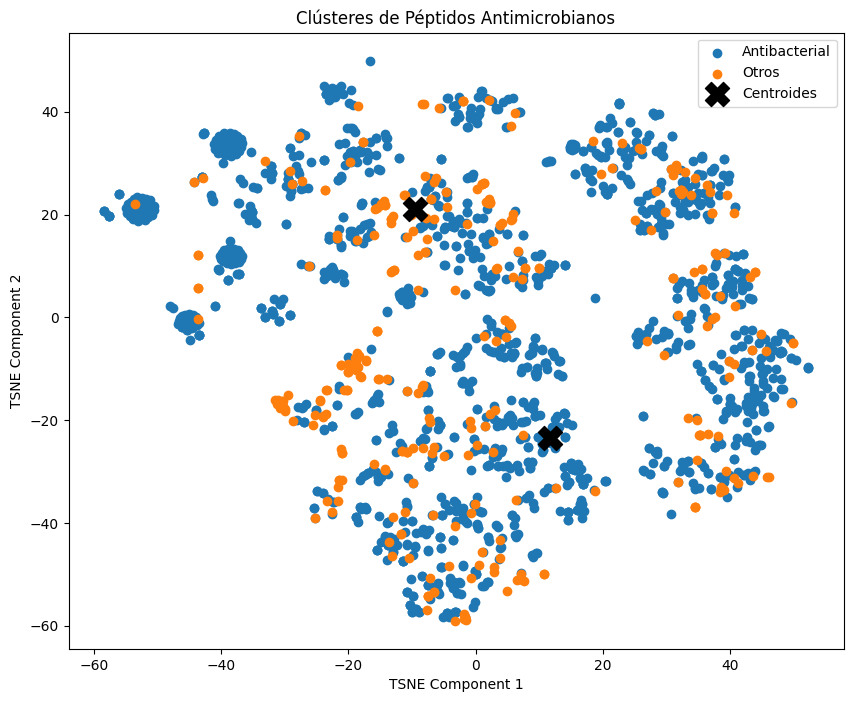

In [20]:
# Visualización de los clústeres
plt.figure(figsize=(10, 8))
for label in np.unique(data['Activity']):
    idx = data['Activity'] == label
    plt.scatter(fingerprints_2d[idx, 0], fingerprints_2d[idx, 1], label=label_encoder.inverse_transform([label])[0])

#Agregar los centroides al gráfico
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='black', marker='X', label='Centroides')

plt.title("Clústeres de Péptidos Antimicrobianos")
plt.xlabel("TSNE Component 1")
plt.ylabel("TSNE Component 2")
plt.legend()
plt.show()
